In [21]:
train.to_csv('/root/autodl-tmp/data/train_data_v2/10w_one-to-multi.csv', index=False)

In [29]:
import pandas as pd

train = pd.read_csv('/root/autodl-tmp/tmp/cc12m.tsv', sep='\t')
train.shape
# train['image_name'] = train.img_dir.apply(lambda x: x.replace('/mnt/cuibenlei.cbl/', '/root/autodl-tmp/data/train_data_v2/'))
# train['image_name'] = train.image_name.apply(lambda x: x.replace('.png', '.jpg'))


(12423374, 2)

In [1]:
import pandas as pd
df = pd.read_parquet('/root/autodl-tmp/coyo-700m/part-00002-17da4908-939c-46e5-91d0-15f256041956-c000.snappy.parquet')
df

,id,url,text,width,height,image_phash,text_length,word_count,num_tokens_bert,num_tokens_gpt,num_faces,clip_similarity_vitb32,clip_similarity_vitl14,nsfw_score_opennsfw2,nsfw_score_gantman,watermark_score,aesthetic_score_laion_v2
0,2353642213324,https://justonebitebaking.files.wordpress.com/...,Aren't they gorgeous,209,209,f3a30969fe38e04c,20,4,5,4,0,0.221436,0.156250,0.007904,0.021115,0.002714,4.939187
1,7533372858735,https://cdn.shopify.com/s/files/1/0533/7019/20...,Berry Merry Beer Can Holder,800,800,a214c9f3e60f263d,27,5,5,5,0,0.264404,0.158569,0.000102,0.025504,0.007722,4.593584
2,6004364530497,https://914444.smushcdn.com/2263071/wp-content...,Flower Lollipops - Free Printable Valentines D...,627,1024,ccac99c9f4c64e34,87,11,24,22,0,0.374512,0.328857,0.000190,0.082411,0.173627,4.888710
3,730144736444,https://cuisinedocbox.com/docs-images/75/71685...,Cheesy Au Gratin Potatoes Serves: 4-6 1 small ...,928,1280,83c8f81bc336db64,196,33,52,47,0,0.302734,0.257324,0.002556,0.041026,0.181127,5.302297
4,6176163152371,https://static.wixstatic.com/media/94dadca0e12...,Feed our Future Vegan School Meals Campaign,980,613,a55a2c364bb45ba9,43,7,8,8,0,0.208130,0.140259,0.013702,0.020492,0.244726,5.517212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5836068,773094115738,https://bt-photos.global.ssl.fastly.net/calgar...,"48 Silverstone Place NW, Calgary, AB (#A111135...",640,427,951f9dd2923462ec,71,9,22,20,0,0.316406,0.281250,0.000041,0.012959,0.006276,5.056959
5836069,858994019006,https://m.media-amazon.com/images/I/41uadN+fds...,Argentinien rugby-trikot 2021 Argentina Rugby ...,500,468,e99696c999499e64,54,8,12,14,0,0.402100,0.380615,0.002710,0.009917,0.034129,4.523453
5836070,618475550691,https://facca.dk/media/mmc.png,Maersk Management Consulting,728,400,b348ccb33348dcb3,28,3,4,5,0,0.386230,0.326172,0.001842,0.005053,0.923832,4.906535
5836071,3109557097999,https://kickz.akamaized.net/fi/media/images/p/...,lacoste Classics Small Croc Hoody NAVY BLUE/NA...,600,600,bab1924bcd2ccd4a,53,9,14,20,0,0.363770,0.333496,0.002035,0.005185,0.028776,4.596506


In [2]:
import unicodedata

def is_english_only(string):
    for s in string:
        cat = unicodedata.category(s)         
        if not cat in ['Ll', 'Lu', 'Nd', 'Po', 'Pd', 'Zs']:
            return False
    return True

def clean_data(df, save_path, prompts_length=5, duplicate_length=10, cfg=5, step=40, sampler=1, ctrl_scale=False):
    """
    prompts_length:
    duplicate_length: reduce duplicate
    cfg: guidance scale,  SD2 default=9,  indicate the similarity of the prompts
    step: SD2 default=50
    sampler:	SD2 default=ddim   Sampler method (hyperparameter). Mapping: {1: "ddim", 2: "plms", 3: "k_euler", 
    4: "k_euler_ancestral", 5: "k_heun", 6: "k_dpm_2", 7: "k_dpm_2_ancestral", 
    8: "k_lms", 9: "others"}.
    ctrl_scale: whether ctrl width and height == 512

    """

    if ctrl_scale:
        df = df[(df['width'] == 512) & (df['height'] == 512)]
        print('after drop non 512 data',df.shape)

    df['prompt'] = df['prompt'].str.strip()

    df = df[df['prompt'].map(lambda x: len(str(x).split())) >= prompts_length]
    df = df[df['prompt'].map(lambda x: len(str(x).split())) <= 77]
    print('after drop few or much prompts', df.shape)
    df = df[~df['prompt'].str.contains('^(?:\s*|NULL|null|NaN)$', na=True)]
    print('after drop nan',df.shape)
    df = df[df['prompt'].apply(is_english_only)]
    print('after drop non english',df.shape)

    # df['head'] = df['prompt'].str[:duplicate_length*4]
    # df['tail'] = df['prompt'].str[-duplicate_length*4:]
    df['head'] = df['prompt'].str.split().str[:duplicate_length].apply(lambda x: ' '.join(x).strip())
    df['tail'] = df['prompt'].str.split().str[-duplicate_length:].apply(lambda x: ' '.join(x).strip())
    df = df.drop_duplicates(subset=['head'])
    print('after drop head duplicate', df.shape)
    df = df.drop_duplicates(subset=['tail'])
    print('after drop tail duplicate', df.shape)

    # df['douhao'] = df['prompt'].str.split(',').apply(lambda x: len(x))
    # df  = df[df['douhao'] < 8]

    df.reset_index(drop=True, inplace=True)
    print('finally:', df.shape)
    # df['length'] = df.prompt.apply(lambda x: len(x.strip().split()))
    # df = df[['image_name', 'prompt', 'length']]
    df[['prompt']].to_csv(save_path, index=False)
    return df
df['prompt'] = df.text
df = clean_data(df, save_path='/root/autodl-tmp/coyo-700m/3.csv', prompts_length=5, duplicate_length=10)

after drop few or much prompts (5100561, 18)
after drop nan (5100561, 18)
after drop non english (4226443, 18)
after drop head duplicate (4189333, 20)
after drop tail duplicate (4166890, 20)
finally: (4166890, 20)


In [6]:
import open_clip
from tqdm import tqdm 
import numpy as np
import pandas as pd
import torch
from PIL import Image
import open_clip
from sentence_transformers import SentenceTransformer, models


df = pd.read_csv('/root/autodl-tmp/coyo-700m/3.csv')

st_model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')
model, _, preprocess = open_clip.create_model_and_transforms('ViT-H-14', pretrained='laion2b_s32b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-H-14')
model.to('cuda')
prompts = df.prompt.tolist()
BATCH_SIZE=1000

def make_batches(l, batch_size=16):
    for i in range(0, len(l), batch_size):
        yield l[i:i + batch_size]

clip_prompts_embedding = []
minillm_prompts_embedding = []
i = 0
for idx, batch in tqdm(enumerate(make_batches(prompts, BATCH_SIZE)), total=len(prompts) //BATCH_SIZE ):

    text = tokenizer(batch).cuda()
    
    nimillm_embedding = st_model.encode(batch, show_progress_bar=False)
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = model.encode_text(text)

    clip_prompts_embedding.extend(text_features.cpu().numpy().astype(np.float16))
    minillm_prompts_embedding.extend(nimillm_embedding.astype(np.float16))


    if (idx+1) % 100 == 0 or (idx+1) == (len(prompts) //BATCH_SIZE):
        print(f'starting save prompt_embeddings_allminilm_{i}.npy')
        np.save(f'/root/autodl-tmp/coyo3/vith14/prompt_embeddings_vith14_{i}.npy', np.stack(clip_prompts_embedding, axis=0))
        np.save(f'/root/autodl-tmp/coyo3/all_minilm_l6_v2/prompt_embedding_allminilm_{i}.npy', np.stack(minillm_prompts_embedding, axis=0))
        clip_prompts_embedding = []
        minillm_prompts_embedding = []
        i += 1


  2%|▏         | 99/4166 [02:28<1:40:49,  1.49s/it]

starting save prompt_embeddings_allminilm_0.npy


  5%|▍         | 199/4166 [04:58<1:38:38,  1.49s/it]

starting save prompt_embeddings_allminilm_1.npy


  7%|▋         | 299/4166 [07:26<1:35:07,  1.48s/it]

starting save prompt_embeddings_allminilm_2.npy


 10%|▉         | 399/4166 [09:54<1:32:27,  1.47s/it]

starting save prompt_embeddings_allminilm_3.npy


 12%|█▏        | 499/4166 [12:22<1:30:37,  1.48s/it]

starting save prompt_embeddings_allminilm_4.npy


 14%|█▍        | 599/4166 [14:51<1:28:24,  1.49s/it]

starting save prompt_embeddings_allminilm_5.npy


 17%|█▋        | 699/4166 [17:20<1:25:22,  1.48s/it]

starting save prompt_embeddings_allminilm_6.npy


 19%|█▉        | 799/4166 [19:49<1:23:03,  1.48s/it]

starting save prompt_embeddings_allminilm_7.npy


 22%|██▏       | 899/4166 [22:17<1:22:10,  1.51s/it]

starting save prompt_embeddings_allminilm_8.npy


 24%|██▍       | 999/4166 [24:46<1:18:13,  1.48s/it]

starting save prompt_embeddings_allminilm_9.npy


 26%|██▋       | 1099/4166 [27:15<1:15:45,  1.48s/it]

starting save prompt_embeddings_allminilm_10.npy


 29%|██▉       | 1199/4166 [29:44<1:13:18,  1.48s/it]

starting save prompt_embeddings_allminilm_11.npy


 31%|███       | 1299/4166 [32:13<1:10:54,  1.48s/it]

starting save prompt_embeddings_allminilm_12.npy


 34%|███▎      | 1399/4166 [34:41<1:08:09,  1.48s/it]

starting save prompt_embeddings_allminilm_13.npy


 36%|███▌      | 1499/4166 [37:10<1:05:50,  1.48s/it]

starting save prompt_embeddings_allminilm_14.npy


 38%|███▊      | 1599/4166 [39:39<1:03:10,  1.48s/it]

starting save prompt_embeddings_allminilm_15.npy


 41%|████      | 1699/4166 [42:07<1:00:47,  1.48s/it]

starting save prompt_embeddings_allminilm_16.npy


 43%|████▎     | 1799/4166 [44:45<1:01:02,  1.55s/it]

starting save prompt_embeddings_allminilm_17.npy


 46%|████▌     | 1899/4166 [47:15<55:56,  1.48s/it]  

starting save prompt_embeddings_allminilm_18.npy


 48%|████▊     | 1999/4166 [49:43<53:29,  1.48s/it]  

starting save prompt_embeddings_allminilm_19.npy


 50%|█████     | 2099/4166 [52:12<50:53,  1.48s/it]

starting save prompt_embeddings_allminilm_20.npy


 53%|█████▎    | 2199/4166 [54:40<48:21,  1.48s/it]

starting save prompt_embeddings_allminilm_21.npy


 55%|█████▌    | 2299/4166 [57:08<46:08,  1.48s/it]

starting save prompt_embeddings_allminilm_22.npy


 58%|█████▊    | 2399/4166 [59:37<43:33,  1.48s/it]

starting save prompt_embeddings_allminilm_23.npy


 60%|█████▉    | 2499/4166 [1:02:05<41:10,  1.48s/it]

starting save prompt_embeddings_allminilm_24.npy


 62%|██████▏   | 2599/4166 [1:04:33<38:33,  1.48s/it]

starting save prompt_embeddings_allminilm_25.npy


 65%|██████▍   | 2699/4166 [1:07:02<36:13,  1.48s/it]

starting save prompt_embeddings_allminilm_26.npy


 67%|██████▋   | 2799/4166 [1:09:30<33:42,  1.48s/it]

starting save prompt_embeddings_allminilm_27.npy


 70%|██████▉   | 2899/4166 [1:11:59<31:24,  1.49s/it]

starting save prompt_embeddings_allminilm_28.npy


 72%|███████▏  | 2999/4166 [1:14:28<28:50,  1.48s/it]

starting save prompt_embeddings_allminilm_29.npy


 74%|███████▍  | 3099/4166 [1:16:56<26:15,  1.48s/it]

starting save prompt_embeddings_allminilm_30.npy


 77%|███████▋  | 3199/4166 [1:19:24<23:53,  1.48s/it]

starting save prompt_embeddings_allminilm_31.npy


 79%|███████▉  | 3299/4166 [1:21:52<21:19,  1.48s/it]

starting save prompt_embeddings_allminilm_32.npy


 82%|████████▏ | 3399/4166 [1:24:20<18:51,  1.48s/it]

starting save prompt_embeddings_allminilm_33.npy


 84%|████████▍ | 3499/4166 [1:26:48<16:27,  1.48s/it]

starting save prompt_embeddings_allminilm_34.npy


 86%|████████▋ | 3599/4166 [1:29:17<13:51,  1.47s/it]

starting save prompt_embeddings_allminilm_35.npy


 89%|████████▉ | 3699/4166 [1:31:44<11:27,  1.47s/it]

starting save prompt_embeddings_allminilm_36.npy


 91%|█████████ | 3799/4166 [1:34:12<09:00,  1.47s/it]

starting save prompt_embeddings_allminilm_37.npy


 94%|█████████▎| 3899/4166 [1:36:40<06:31,  1.47s/it]

starting save prompt_embeddings_allminilm_38.npy


 96%|█████████▌| 3999/4166 [1:39:07<04:05,  1.47s/it]

starting save prompt_embeddings_allminilm_39.npy


 98%|█████████▊| 4099/4166 [1:41:35<01:38,  1.48s/it]

starting save prompt_embeddings_allminilm_40.npy


100%|█████████▉| 4165/4166 [1:43:13<00:01,  1.48s/it]

starting save prompt_embeddings_allminilm_41.npy


4167it [1:43:16,  1.49s/it]                          


In [28]:
minillm_prompts_embedding[0]

array([-8.0414e-03, -3.4485e-02,  6.9458e-02,  2.5452e-02, -2.9335e-03,
        4.2686e-03,  8.4351e-02, -1.2566e-02, -6.2683e-02,  6.1676e-02,
        2.7637e-03, -1.7786e-01, -4.0314e-02, -4.2686e-03, -6.2927e-02,
        4.3793e-03,  5.1117e-02,  3.8849e-02, -3.8910e-02,  8.6426e-02,
        1.8723e-02, -2.7374e-02,  4.2725e-02,  5.6885e-02, -3.0594e-02,
        5.2681e-03,  9.1248e-03,  5.2338e-02,  1.8051e-02, -9.9365e-02,
       -5.6091e-02,  2.4551e-02,  6.1157e-02,  8.2703e-03,  5.6122e-02,
        5.2063e-02, -5.6030e-02, -3.2867e-02,  2.8091e-02,  3.2562e-02,
       -5.0568e-02, -3.6255e-02, -2.8534e-03,  1.3908e-02,  3.0869e-02,
       -9.9945e-03,  4.1321e-02,  2.9564e-03, -4.4586e-02, -4.7028e-02,
       -8.2947e-02, -9.6558e-02, -1.1084e-01,  1.8417e-02, -4.3335e-02,
       -3.3661e-02, -3.4271e-02, -5.2368e-02,  4.0436e-02, -5.3680e-02,
        2.1545e-02, -4.1748e-02,  9.9258e-03,  3.9856e-02, -7.2449e-02,
        5.8060e-03, -8.1482e-02,  1.6403e-02,  8.7738e-03, -2.26

In [5]:
import numpy as np
np.load('/root/autodl-tmp/coyo2/all_minilm_l6_v2/prompt_embedding_allminilm_0.npy') == np.load('/root/autodl-tmp/coyo/all_minilm_l6_v2/prompt_embedding_allminilm_0.npy')

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [10]:
train.shape

(311459, 3)

In [14]:
train.to_csv('/root/autodl-tmp/data/train_data_v2/one2multi0509_sum.csv', index=False)

(512, 512, 3)
Bugs Bunny as a Nintendo 64 console, in the style of Looney Tunes.


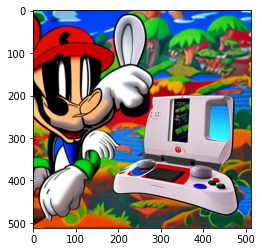

(512, 512, 3)
Hello Kitty as a Nintendo DS console, in the style of Sanrio.


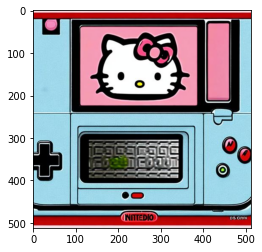

(512, 512, 3)
NES platformer character sprite of a superhero Abraham Lincoln.


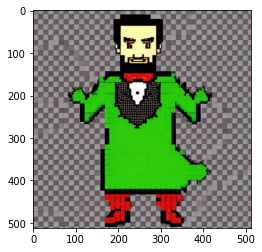

(512, 512, 3)
PS4 action-adventure game cover art featuring a cyborg Cleopatra.


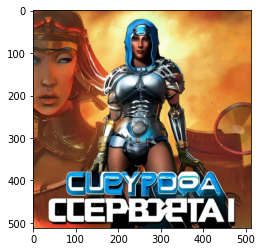

(512, 512, 3)
GameBoy Color puzzle game level design with a ninja Julius Caesar.


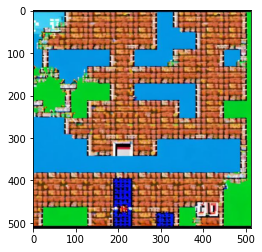

(512, 512, 3)
Xbox RPG party roster including a mage Napoleon Bonaparte.


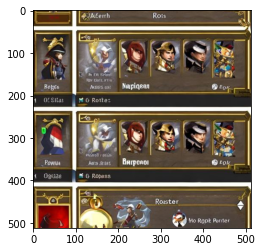

(512, 512, 3)
Atari 2600 side-scroller game screen with a robot Joan of Arc.


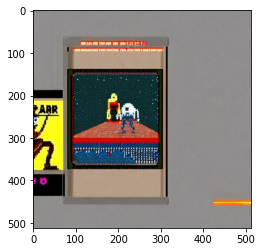

(512, 512, 3)
SNES beat 'em up game boss fight against a zombie King Arthur.


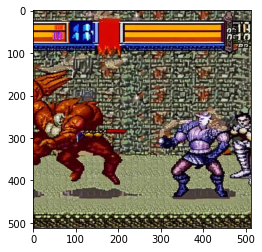

(512, 512, 3)
Nintendo DS visual novel game artwork showcasing a vampire Mary Queen of Scots.


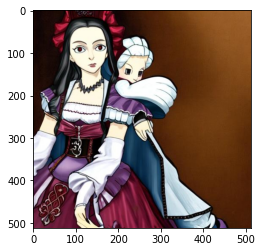

(512, 512, 3)
PC strategy game faction led by a werewolf Genghis Khan.


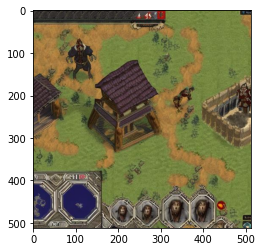

In [12]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd


for i, row in train[100000:100010].iterrows():
    prompt = row.prompt
    path = row.image_name
    img = cv2.imread(path)[...,::-1]
    print(img.shape)
    print(prompt)
    plt.imshow(img)
    plt.show()

In [5]:
train.image_name.tolist()

['/root/autodl-tmp/data/train_data_v2/one2multi0505_0/samples/00000000.png',
 '/root/autodl-tmp/data/train_data_v2/one2multi0505_0/samples/00000001.png',
 '/root/autodl-tmp/data/train_data_v2/one2multi0505_0/samples/00000002.png',
 '/root/autodl-tmp/data/train_data_v2/one2multi0505_0/samples/00000003.png',
 '/root/autodl-tmp/data/train_data_v2/one2multi0505_0/samples/00000004.png',
 '/root/autodl-tmp/data/train_data_v2/one2multi0505_0/samples/00000005.png',
 '/root/autodl-tmp/data/train_data_v2/one2multi0505_0/samples/00000006.png',
 '/root/autodl-tmp/data/train_data_v2/one2multi0505_0/samples/00000007.png',
 '/root/autodl-tmp/data/train_data_v2/one2multi0505_0/samples/00000008.png',
 '/root/autodl-tmp/data/train_data_v2/one2multi0505_0/samples/00000009.png',
 '/root/autodl-tmp/data/train_data_v2/one2multi0505_0/samples/00000010.png',
 '/root/autodl-tmp/data/train_data_v2/one2multi0505_0/samples/00000011.png',
 '/root/autodl-tmp/data/train_data_v2/one2multi0505_0/samples/00000012.png',

In [10]:
train.to_csv('/root/autodl-tmp/data/train_data_v2/one2multi0505_sum.csv', index=False)

In [12]:
merge.to_csv('new_71w_train_data.csv', index=False)

In [13]:
merge

,img_dir,prompt,head,tail,douhao,length,index,image_name,image_path,cos
0,/mnt/cuibenlei.cbl/chatgpt_one2multi_prompt_1/...,Cyberpunk cover art for an upcoming Radiohead ...,Cyberpunk cover art for an upcoming Radiohead ...,Cyberpunk cover art for an upcoming Radiohead ...,1,8,0,NaN,NaN,NaN
1,/mnt/cuibenlei.cbl/chatgpt_one2multi_prompt_1/...,A portrait of a poodle wearing a hat.,A portrait of a poodle wearing a hat.,A portrait of a poodle wearing a hat.,1,8,1,NaN,NaN,NaN
2,/mnt/cuibenlei.cbl/chatgpt_one2multi_prompt_1/...,A cartoon of a jack russell terrier wearing a ...,A cartoon of a jack russell terrier wearing a ...,A cartoon of a jack russell terrier wearing a ...,1,10,2,NaN,NaN,NaN
3,/mnt/cuibenlei.cbl/chatgpt_one2multi_prompt_1/...,"""Ephemeral dreams on the winding spiral path t...","""Ephemeral dreams on the winding spiral path t...","on the winding spiral path to Nirvana"" by Taka...",1,12,3,NaN,NaN,NaN
4,/mnt/cuibenlei.cbl/chatgpt_one2multi_prompt_1/...,"""Continuous hope on the eternal circular stair...","""Continuous hope on the eternal circular stair...","on the eternal circular staircase to infinity""...",1,12,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
712407,/mnt/cuibenlei.cbl/chatgpt_prompt_8/samples/00...,"Pikachu from Pokémon in a forest, bokeh, portr...","Pikachu from Pokémon in a forest, bokeh, portr...","forest, bokeh, portrait, photography, 8 5 mm l...",6,15,720686,NaN,NaN,NaN
712408,/mnt/cuibenlei.cbl/chatgpt_prompt_8/samples/00...,Star Wars Jedi Council chamber with circular b...,Star Wars Jedi Council chamber with circular b...,Star Wars Jedi Council chamber with circular b...,1,8,720687,NaN,NaN,NaN
712409,/mnt/cuibenlei.cbl/chatgpt_prompt_8/samples/00...,"A portrait of Bart Simpson by Pablo Picasso, w...","A portrait of Bart Simpson by Pablo Picasso, w...","A portrait of Bart Simpson by Pablo Picasso, w...",2,10,720688,NaN,NaN,NaN
712410,/mnt/cuibenlei.cbl/chatgpt_prompt_8/samples/00...,Surreal sculpture of a giant ear made entirely...,Surreal sculpture of a giant ear made entirely...,"ear made entirely out of flowers, captured in ...",2,15,720689,NaN,NaN,NaN


In [12]:

import os
from PIL import Image
from joblib import Parallel, delayed
from tqdm import tqdm
import cv2
data = pd.read_csv('/root/autodl-tmp/data/train_data_v2/10w_one-to-multi.csv')
import warnings
import os
import warnings


def check_images(idx, row):
    filename = row.image_name
    if filename.endswith('.jpg'):
        try:
            img = cv2.imread(filename)
        except UserWarning:
            print(filename)

valid_images = Parallel(n_jobs=8)(delayed(check_images)(idx, row) for idx, row in tqdm(data.iterrows(), total=len(data)))  



100%|██████████| 100970/100970 [00:18<00:00, 5353.36it/s]


In [13]:

import os
from PIL import Image
from joblib import Parallel, delayed
from tqdm import tqdm
import cv2
data = pd.read_csv('/root/autodl-tmp/data/train_data_v2/10w_one-to-multi.csv')
import warnings
import os
import warnings


def remove_images(idx, row):
    filename = row.image_name
    filename = filename.replace('.jpg', '.png')
    if filename.endswith('.png'):
        try:
            os.remove(filename)
        except UserWarning:
            print(filename)

valid_images = Parallel(n_jobs=8)(delayed(remove_images)(idx, row) for idx, row in tqdm(data.iterrows(), total=len(data)))  



100%|██████████| 100970/100970 [00:18<00:00, 5362.96it/s]


In [10]:
valid_images = [i for i in valid_images if i != None]
data = data.iloc[valid_images, :]
data


IndexError: positional indexers are out-of-bounds

Drake Bell posing with fans at a concert.


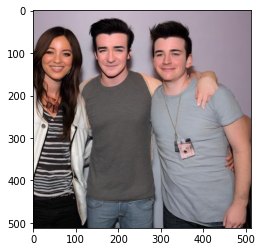

Drake Campana taking a bike ride in the park.


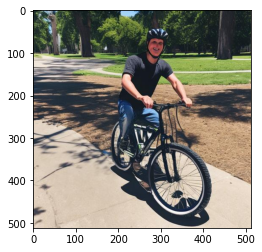

A musician's studio by Mia Brown.


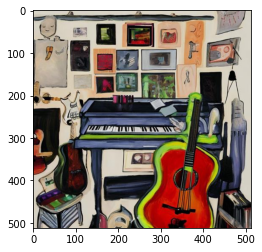

A calligrapher's workspace by Ava Lee.


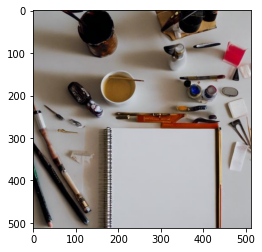

A sculpture of a wolf in a futuristic gothic style made from parts of broken keyboards and attached together.


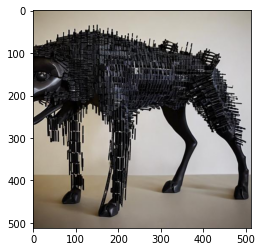

Crying man with bird wings holding broken umbrella, photo from rainy day.


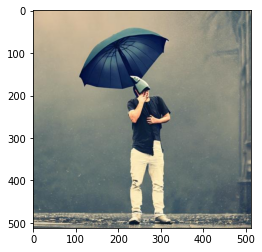

Joyful boy with clown nose holding colorful balloon bouquet, photo from birthday party.


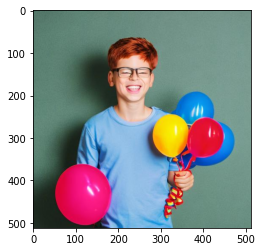

Michael Jackson in the Family Guy animation.


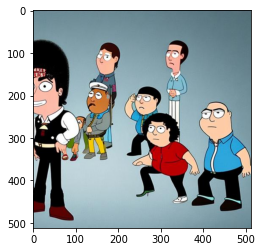

Cybernetic Statue of Freedom by Emily Coleman, Ryan Johnson, and Laura Hudson.


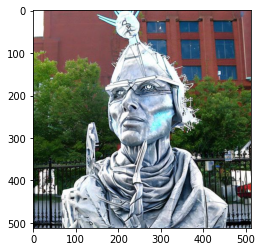

Poster for Evil Dead 4: Return of the Deadites.


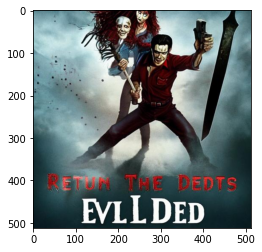

In [25]:
import torch
from PIL import Image
import open_clip
import matplotlib.pyplot as plt

if __name__ == '__main__':
    import pandas as pd

    data = pd.read_csv('/root/autodl-tmp/data/train_data_v2/10w_one-to-multi.csv')[10000:10010]

    for i, row in data.iterrows():
        img_path = row.image_name
        # img_path = '/root/autodl-tmp/data/train_data_v2/' + img_path.replace('.png', '.jpg')
        prompt = row.prompt
        print(prompt)
        plt.imshow(Image.open(img_path))
        plt.show()
        # break

 

In [35]:
train['image_name'] = train.image_path.apply(lambda x: x.split('/')[-1])

In [36]:
train['image_name'] = train.image_name.apply(lambda x: '/root/autodl-tmp/data/val/eval_images/' + x.replace('.png', '.jpg'))
train

,image_path,prompt,image_name
0,/root/autodl-tmp/eval_images/hardcode_0.jpg,"Lively tropical island, where the elements con...",/root/autodl-tmp/data/val/eval_images/hardcode...
1,/root/autodl-tmp/eval_images/hardcode_2.jpg,"running, white, Norman, with a sense of sereni...",/root/autodl-tmp/data/val/eval_images/hardcode...
2,/root/autodl-tmp/eval_images/hardcode_3.jpg,"ancient Greece, where the earth meets the sky,...",/root/autodl-tmp/data/val/eval_images/hardcode...
3,/root/autodl-tmp/eval_images/hardcode_4.jpg,"where the veil between worlds is thin, sewing,...",/root/autodl-tmp/data/val/eval_images/hardcode...
4,/root/autodl-tmp/eval_images/hardcode_5.jpg,with a sense of enchantment that lingers long ...,/root/autodl-tmp/data/val/eval_images/hardcode...
...,...,...,...
50978,/root/autodl-tmp/eval_images/eval_00008083.jpg,"concept art of asian female Void Walker, slavi...",/root/autodl-tmp/data/val/eval_images/eval_000...
50979,/root/autodl-tmp/eval_images/eval_00008130.jpg,"huge, 8 k, trending on artstation, rule of thi...",/root/autodl-tmp/data/val/eval_images/eval_000...
50980,/root/autodl-tmp/eval_images/eval_00008164.jpg,A new generation of bionicle set in a cyberpun...,/root/autodl-tmp/data/val/eval_images/eval_000...
50981,/root/autodl-tmp/eval_images/eval_00008169.jpg,a tornado made of neon lights sucking in the l...,/root/autodl-tmp/data/val/eval_images/eval_000...


In [37]:
train.image_name.tolist()[0]

'/root/autodl-tmp/data/val/eval_images/hardcode_0.jpg'

In [38]:
train.to_csv('/root/autodl-tmp/data/val/final_eval.csv', index=False)

In [10]:
paths = train['paths'].tolist()
import cv2
import os
from tqdm import tqdm
from urllib.request import urlretrieve
from tqdm import tqdm
from joblib import Parallel, delayed
import pandas as pd
def check(path):
    try:
        img = cv2.imread(path)
        return
    except:

        return  path


loss = Parallel(n_jobs=16, backend='multiprocessing')(delayed(check)(row) for row in tqdm(paths, total=len(paths)))
[i for i in loss if i != None]



100%|██████████| 339074/339074 [00:53<00:00, 6324.14it/s]


[]

In [12]:
import cv2

print(cv2.imread('/root/autodl-tmp/data/train_data_v1/USEFUL_TRAIN_v1/6d2f4f76-ccad-4fd7-813e-f699df31d209.jpg'))


None


Yoda drinking tea in a garden filled with floating lanterns, calming atmosphere, matte painting, trending on DeviantArt, anime style, painted by Hayao Miyazaki.


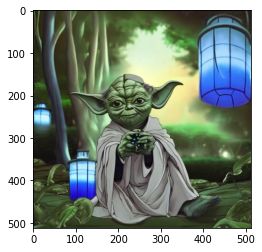

In [15]:

import pandas as pd
import cv2
import matplotlib.pyplot as plt

train = pd.read_csv('./data/train_data_v2/v2_train.csv')
train = train[~train['image_name'].str.contains('diffusion_output_sdv1_30w_part_4')][152000:]

for i, row in train.iterrows():
    name = row.image_name.replace('.png', '.jpg')
    path = 'data/train_data_v2/' + name
    prompt = row.prompt
    print(prompt)
    img = cv2.imread(path)
    plt.imshow(img)
    plt.show()

    break

A tiger lounging in a hammock, watching the sunset, minimalist, line art


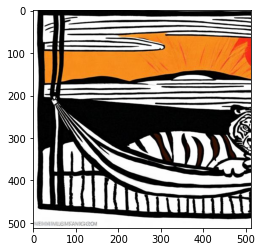

Label probs: tensor([[0.4477]])
A digital drawing of a family of pandas lounging in a bamboo forest


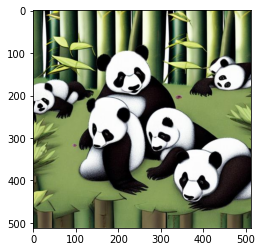

Label probs: tensor([[0.3772]])
A cute puppy with a tie, holding a briefcase and walking through a bustling city.


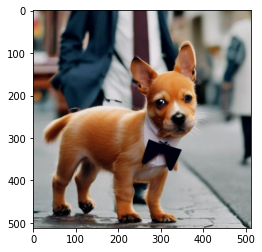

Label probs: tensor([[0.3352]])
A charming snowman with a carrot nose and a top hat, in a winter wonderland, illustrated by Mary Engelbreit, holiday art.


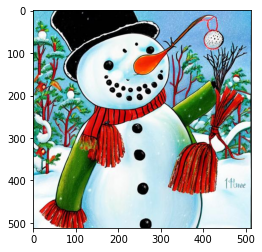

Label probs: tensor([[0.3410]])
Gigantic hamburger rolling down the street of New York City, skyscrapers, bustling crowd, ultra-realistic, 3d.


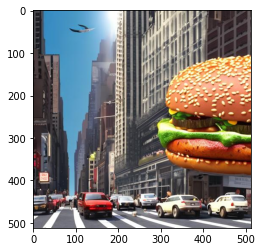

Label probs: tensor([[0.4239]])
Sunrise over the African savannah, vibrant oranges and reds blending into purple hues, distant herd of elephants, hot air balloon drifting in the sky, painted by Thomas Kinkade.


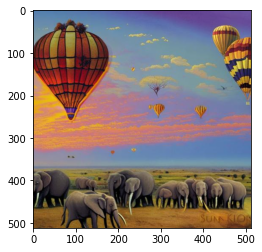

Label probs: tensor([[0.3539]])
Peaceful landscape of a serene forest, with deer grazing and birds flying, done in a pastel art style.


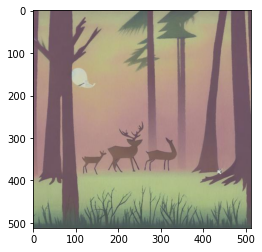

Label probs: tensor([[0.3305]])
An intense chase sequence of Bugs Bunny being followed by the Road Runner in an acrylic painting, abstract expressionism.


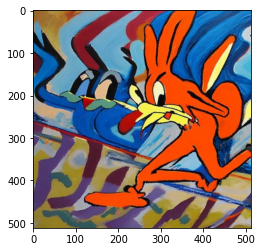

Label probs: tensor([[0.3795]])
A scene from a horror movie with a terrifying monster lurking in the shadows, illustrated by Junji Ito, psychological horror, surreal, creepy.


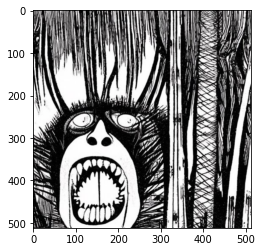

Label probs: tensor([[0.3742]])
Photorealistic portrait of a leopard, intense, fierce, 1080p, CryEngine, Octane Render in the style of Leonardo da Vinci and Albrecht Durer.


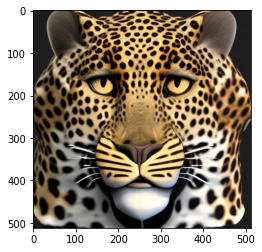

Label probs: tensor([[0.3152]])


In [5]:
import torch
from PIL import Image
import open_clip
import matplotlib.pyplot as plt
def clip(img_path, prompt):


    model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='laion2b_s32b_b82k')
    tokenizer = open_clip.get_tokenizer('ViT-L-14')

    image = preprocess(Image.open(img_path)).unsqueeze(0)
    text = tokenizer(prompt)
    print(prompt)
    plt.imshow(Image.open(img_path))
    plt.show()
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        text_probs = (image_features @ text_features.T)

    print("Label probs:", text_probs)  # prints: [[1., 0., 0.]]

if __name__ == '__main__':
    import pandas as pd

    data = pd.read_csv('/root/autodl-tmp/data/train_data_v2/v2_train.csv')[10000:10010]
    for i, row in data.iterrows():
        img_path = row.image_name
        img_path = '/root/autodl-tmp/data/train_data_v2/' + img_path.replace('.png', '.jpg')
        prompt = row.prompt
        clip(img_path, prompt)
        # break
    

In [10]:
import pandas as pd
import cv2

cv2.imread('/root/autodl-tmp/data/train_data_v1/laion2d_filtered/00000000_zi_10bfa6e0-bbb4-4468-bec0-977cd8561833.jpg').shape

(480, 414, 3)

In [10]:
dirname = data.tolist()[500000].split('/')[3]
imgname = data.tolist()[500000].split('/')[-1]
newname = dirname+ '/' + dirname + "_" + imgname
newname

'diffusion_output_part_3_v3/diffusion_output_part_3_v3_00015327.png'

In [27]:
dirname = data.str.split('/').str[3]
imgname = data.str.split('/').str[-1]

In [28]:
newname = dirname+ '/' + dirname + "_" + imgname
newname

0          chatgpt_prompt_10/chatgpt_prompt_10_00000000.png
1          chatgpt_prompt_10/chatgpt_prompt_10_00000001.png
2          chatgpt_prompt_10/chatgpt_prompt_10_00000002.png
3          chatgpt_prompt_10/chatgpt_prompt_10_00000003.png
4          chatgpt_prompt_10/chatgpt_prompt_10_00000004.png
                                ...                        
590442    diffusion_output_part_9_v3/diffusion_output_pa...
590443    diffusion_output_part_9_v3/diffusion_output_pa...
590444    diffusion_output_part_9_v3/diffusion_output_pa...
590445    diffusion_output_part_9_v3/diffusion_output_pa...
590446    diffusion_output_part_9_v3/diffusion_output_pa...
Name: img_dir, Length: 590447, dtype: object

In [29]:
prompts = pd.read_csv('/root/autodl-tmp/data/train_data_v2/diffusion_prompt_filtered_all.csv').iloc[:, 1]

In [30]:
data = pd.DataFrame()
data['image_name'] = newname
data['prompt'] = prompts

In [31]:
data.to_csv('tmp.csv', index=False)

In [2]:
import pandas as pd
newdata = pd.read_csv('/root/autodl-tmp/tmp.csv')
newdata

,image_name,prompt
0,chatgpt_prompt_10/chatgpt_prompt_10_00000000.png,"Golden Retriever with the face of Beyonce, oil..."
1,chatgpt_prompt_10/chatgpt_prompt_10_00000001.png,Joan of Arc leading an army into battle on hor...
2,chatgpt_prompt_10/chatgpt_prompt_10_00000002.png,Michelangelo's David transformed into a superh...
3,chatgpt_prompt_10/chatgpt_prompt_10_00000003.png,"Abandoned lighthouse on a tranquil beach, stil..."
4,chatgpt_prompt_10/chatgpt_prompt_10_00000004.png,"Hermione Granger as a character in Minecraft,"
...,...,...
590442,diffusion_output_part_9_v3/diffusion_output_pa...,photo of satan at the gateway to hell
590443,diffusion_output_part_9_v3/diffusion_output_pa...,"color painting, highly realistic, heavyset man..."
590444,diffusion_output_part_9_v3/diffusion_output_pa...,a combination of barack obama and will smith
590445,diffusion_output_part_9_v3/diffusion_output_pa...,"medieval art, bearded man kissing bearded man"


In [3]:
image_names = newdata.image_name.tolist()
import cv2
from tqdm import tqdm
from joblib import Parallel, delayed

import os
def check(img):
    path = '/root/autodl-tmp/data/train_data_v2/' + img

    if not os.path.exists(path):
        return path
        # a = cv2.imread(path)
        # if a is None:

    return 

loss = Parallel(n_jobs=32)(delayed(check)(image) for image in tqdm(image_names, total=len(image_names)))

100%|██████████| 590447/590447 [00:12<00:00, 46901.91it/s] 


In [4]:
loss = [i for i in loss if i is not None]
len(loss)

12000

In [6]:
set([i.split('/')[-2] for i in loss])

{'diffusion_output_sdv1_30w_part_4'}

In [1]:
from glob import glob

jsons = glob("/media/benny/新加卷/StableDiffusionDB/*")
len(jsons)

2004

In [ ]:
import json
import pandas as pd
all_data = pd.DataFrame()
for path in jsons:
   with open(path, 'r') as fcc_file:
    fcc_data = json.load(fcc_file)
    print(len(fcc_data))

    break

In [ ]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

a = cv2.imread('dataset/StableDiffusionDB/part-000001/000b7b74-0a22-4d0c-b717-e240fdc5d555.png')
plt.imshow(a)
plt.show()
cv2.imwrite('./a.webp', a)
cv2.imwrite('./a.jpg', a)

In [ ]:
b = Image.open('a.jpg')
plt.imshow(b)
plt.show()

In [ ]:
from glob import glob
from tqdm import tqdm
import os
db = glob('./dataset/StableDiffusionDB/part*')
idxs = []
for idx, i in enumerate(tqdm(db, total=len(db))):
    idxs.append(i.split("/")[-1].split('-')[-1])


In [ ]:
len(idxs)

In [1]:
import pandas as pd

df = pd.read_csv('SAZUMA_fliter_data2.csv')
df['filepath'] = '/benny/SDIP/'+df['image_name']
df['title'] = df['[prompt]']
df


KeyError: '[prompt]'

In [ ]:
data['image_name'] = data.image_path.apply(lambda x: 'val_'+x.split('/')[-1])
data

In [ ]:
data['prompt'] = data.Prompt
data[['image_name', 'prompt']].to_csv('./dataset/v2_eval.csv', index=False)

In [ ]:
data2 = pd.read_csv('/home/benny/SDIP/dataset/v2_val_date.csv')
data2

In [ ]:
new_val = pd.concat([data2, data[['image_name', 'prompt']]])
new_val

In [ ]:
new_val.to_csv('./dataset/v2_all.csv', index=False)

In [ ]:
a = []
with open('extra.txt', 'r') as f:
    a = f.readlines()
a

In [ ]:
a[0].strip()

In [ ]:
import os

img = data.image_name.values.tolist()
for i in img:
    path = os.path.join('dataset/StableDiffusionDB_all',i)
    if os.path.exists(path):
        pass
    else:
        print(path)

In [ ]:
import unicodedata
def is_english_only(string):
    for s in string:
        cat = unicodedata.category(s)         
        if not cat in ['Ll', 'Lu', 'Nd', 'Po', 'Pd', 'Zs']:
            return False
    return True


def clean_data(path, save_path):
    small = pd.read_parquet(path)
    print('origin data',small.shape)
    # small = small[(small['width'] == 512) & (small['height'] == 512)]
    # print(small.shape)
    small['prompt'] = small['prompt'].str.strip()
    print(small.shape)
    small = small[small['prompt'].map(lambda x: len(x.split())) >= 5]
    print('drop few prompts', small.shape)
    small = small[~small['prompt'].str.contains('^(?:\s*|NULL|null|NaN)$', na=True)]
    print('drop nan',small.shape)
    small = small[small['prompt'].apply(is_english_only)]
    print('drop no english',small.shape)
    # small['head'] = small['prompt'].str[:15]
    # small['tail'] = small['prompt'].str[-15:]
    # small.drop_duplicates(subset='head', inplace=True)
    # print(small.shape)
    # small.drop_duplicates(subset='tail', inplace=True)
    # print(small.shape)
    small.reset_index(drop=True, inplace=True)
    small[['image_name','prompt']].to_csv(save_path, index=False)

path  = "./dataset/StableDiffusionDB/metadata.parquet"
clean_data(path, "./dataset/StableDiffusionDB/clean_data.csv")

In [ ]:
import os
import json

dics = {}
for path, file_dir, files in os.walk('./dataset/杂七杂八'):
    for file_name in files:
        file_path = os.path.abspath(os.path.join(path, file_name))
        name = file_path.split('/')[-1]
        if name.endswith('.webp'):
            dics[name] = file_path


with open('all_data.json', 'w') as f:
    json.dump(dics, f)

In [ ]:

with open('all_data.pickle', 'br') as f:
    a = pickle.load(f)
a

In [ ]:
import pandas as pd

data = pd.read_parquet('./dataset/StableDiffusionDB/metadata-large.parquet')


In [ ]:
import numpy as np
from collections import Counter
steps = np.array(data.step.values.tolist())
count = Counter(steps)

In [ ]:
data[(data['cfg'] > 6) & (data['step'] > 40)]

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

path = './dataset/StableDiffusionDB_all/'
img = Image.open(path+'002ba8c8-8a1a-4556-a1b2-0small1394ade13.png')
plt.imshow(img)
plt.show()


In [ ]:
a = 0    #<20
b = 0    #20-40
c = 0    #40-60
d = 0    #60+
for i in sorted (count) : 
    if i < 20:
        a += count[i]
    elif  20 <= i <= 40:
        b += count[i]
    elif  40 < i <= 60:
        c += count[i]
    else:
        d += count[i]
a,b,c,d  


In [ ]:
import pandas as pd
small = pd.read_parquet('./dataset/StableDiffusionDB/metadata.parquet')

In [ ]:
small = small[(small.cfg > 5) & (small.step > 40)]
small.shape

In [ ]:
import unicodedata
def is_english_only(string):
    for s in string:
        cat = unicodedata.category(s)         
        if not cat in ['Ll', 'Lu', 'Nd', 'Po', 'Pd', 'Zs']:
            return False
    return True

# print(small.shape)
# small = small[(small['width'] == 512) & (small['height'] == 512)]
print(small.shape)
small['prompt'] = small['prompt'].str.strip()
print(small.shape)
small = small[small['prompt'].apply(lambda x: len(x.split(" "))) >= 5]
print(small.shape)
small = small[~small['prompt'].str.contains('^(?:\s*|NULL|null|NaN)$', na=True)]
print(small.shape)
small = small[small['prompt'].apply(is_english_only)]
print(small.shape)
small['head'] = small['prompt'].str[:15]
small['tail'] = small['prompt'].str[-15:]
# small.drop_duplicates(subset='head', inplace=True)
print(small.shape)
# small.drop_duplicates(subset='tail', inplace=True)
print(small.shape)
small.reset_index(drop=True, inplace=True)
small.shape

In [ ]:
small.head(5)

In [ ]:
small[['image_name', 'prompt']].to_csv('./dataset/StableDiffusionDB/clean_data.csv', index=False)

In [ ]:
import pandas as pd
import os

len(os.listdir('/benny/SDIP/'))

In [ ]:
data

In [ ]:
data['head'] = data['prompt'].str.split(' ').str[:30].apply(lambda x: ' '.join(x).strip('\n'))
data['tail'] = data['prompt'].str.split(' ').str[-30:].apply(lambda x: ' '.join(x).strip('\n'))


In [ ]:
data = data.drop_duplicates(subset=['head'], inplace=False)
data = data.drop_duplicates(subset=['tail'], inplace=False)
data

In [ ]:
data.to_csv('./dataset/drop_duplicate.csv', index=False)

In [ ]:
small = data[['image_name', 'prompt']]
small['length'] = small.prompt.apply(lambda x: len(x.strip().split()))

In [ ]:
b = small['length'].value_counts().sort_values().to_dict()
b

In [ ]:
small['appear_counts'] = small.length.map(b)

In [ ]:
clean_data = small[['image_name', 'prompt', 'length', 'appear_counts']]

In [ ]:
idx = clean_data[clean_data['appear_counts'] < 10].index



In [ ]:
clean_data.loc[idx, 'appear_counts'] = 0

In [ ]:
clean_data.to_csv("fliter_data.csv", index=False)


In [ ]:
clean_data.to_csv("./dataset/StableDiffusionDB/clean_data.csv", index=False)

In [ ]:
clean_data.shape

In [ ]:
df['head'] = df['prompt'].str.split(' ').str[:20].apply(lambda x: ' '.join(x).strip())
df['tail'] = df['prompt'].str.split(' ').str[-20:].apply(lambda x: ' '.join(x).strip())
df = df.duplicates(subset=['head'], inplace=False)
df = df.duplicates(subset=['tail'], inplace=False)

In [ ]:
import os

len(os.listdir('./dataset/StableDiffusionDB'))

In [ ]:
import pandas as pd

data = pd.read_csv('filter_eval_v2.csv')
data.iloc[:100,:].to_csv('./a.csv', index=False)
data.shape

In [ ]:
data['prompt'] = data['Prompt']
data[['image_name', 'prompt']].to_csv('./dataset/v2_val_date.csv', index=False)

In [ ]:
import timm
import torch
import random
import os
import numpy as np
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=False,
    num_classes=384
)
model.set_grad_checkpointing()
state_dict = torch.load('vit_base_patch16_224.pth')
model.load_state_dict(state_dict)
model.cuda()
model.eval()
with open('random_data.pkl', 'rb') as f:
    x = pickle.load(f)
y = model(x.cuda())
print(y)


In [ ]:
random_data = torch.randn((128, 3, 224, 224))
with open('random_data.pkl', 'bw') as f:
    pickle.dump(random_data, f)

In [ ]:
import pickle
with open('output.pkl', 'rb') as f:
    a = pickle.load(f)

In [ ]:
a = torch.tensor(a).cuda()
a - y

In [ ]:
from scipy import spatial
import numpy as np

def cosine_similarity(y_trues, y_preds):
    return np.mean([
        1 - spatial.distance.cosine(y_true, y_pred) 
        for y_true, y_pred in zip(y_trues, y_preds)
    ])

# np.sqrt(np.mean((y.cpu().detach().numpy() - a.cpu().detach().numpy()) ** 2))
cosine_similarity(y.cpu().detach().numpy(), a.cpu().detach().numpy())


In [2]:
import pandas as pd

data = pd.read_parquet('/root/autodl-tmp/tmp/laion400m-data-part-000000/00000.parquet')
data

,caption,url,key,status,error_message,width,height,original_width,original_height,exif,md5
0,Good Evening New York City album artwork - Pau...,http://i0.wp.com/www.beatlesbible.com/wp/media...,000000017,success,None,512.0,512.0,580.0,580.0,{},093ea94f0d717d6d1baeeb65c140ac6c
1,Curtains Ideas cold weather curtains : Stylish...,https://i1.wp.com/www.hometone.com/wp-content/...,000000029,failed_to_download,HTTP Error 404: Not Found,NaN,NaN,NaN,NaN,None,None
2,Isolated quince jam jar and fruit,https://thumbs.dreamstime.com/x/isolated-quinc...,000000000,success,None,512.0,512.0,400.0,400.0,{},dd7627f62fb52649c94d71ba4feb7969
3,turquoise animal Washi Masking Tape deco tape ...,https://i0.wp.com/blog.modes4u.com/images/Tons...,000000035,failed_to_download,HTTP Error 404: Not Found,NaN,NaN,NaN,NaN,None,None
4,40% off Bridal Wedding Jewelry Sets Silver Col...,https://ae01.alicdn.com/kf/HTB1H0hPaH1YBuNjSsz...,000000038,success,None,512.0,512.0,800.0,800.0,"{""Image XResolution"": ""72"", ""Image YResolution...",a7ea1031b0873eac0c44528e3024b9dd
...,...,...,...,...,...,...,...,...,...,...,...
9995,Meet & Greet Hello Kitty,https://www.jbproductions.nl/images/artiest/ne...,000009956,failed_to_download,The read operation timed out,NaN,NaN,NaN,NaN,None,None
9996,Continuing innovation at IMEX in Frankfurt 201...,https://conferencematters.nl/wp-content/upload...,000009704,success,None,512.0,512.0,750.0,500.0,{},7d1a332b7226960b69c53b09cb096826
9997,Sunlight pierces through a dense green canopy,https://theecologist.org/siteimage/scale/100/1...,000008746,failed_to_download,The read operation timed out,NaN,NaN,NaN,NaN,None,None
9998,PGH Ambulance - 1927 Packard,http://www.lougopal.com/manila/wp-content/uplo...,000009927,failed_to_download,timed out,NaN,NaN,NaN,NaN,None,None


In [9]:
from PIL import Image
from glob import glob
import pandas as pd
from tqdm import tqdm
img_paths = glob('/root/autodl-tmp/tmp/laion400m-data-part-000000/*/*jpg')
cap_paths = glob('/root/autodl-tmp/tmp/laion400m-data-part-000000/*/*txt')
img_paths = sorted(img_paths, key=lambda x: int(x.split('/')[-1][:-4]))
cap_paths = sorted(cap_paths, key=lambda x: int(x.split('/')[-1][:-4]))
data = pd.DataFrame()
image_paths = []
prompt_paths = []
for i, j in tqdm(zip(img_paths, cap_paths), total=len(img_paths)):
    image_paths.append(i)
    # prompt_paths.append(j)
    with open(j, 'r') as f:
        prompt_paths.append(f.readline().strip())
    # break
data['image_name'] = image_paths
data['prompt'] = prompt_paths
data

100%|██████████| 651177/651177 [00:11<00:00, 55305.97it/s]


,image_name,prompt
0,/root/autodl-tmp/tmp/laion400m-data-part-00000...,Isolated quince jam jar and fruit
1,/root/autodl-tmp/tmp/laion400m-data-part-00000...,Curious Critters Club - Logo English Kids Long...
2,/root/autodl-tmp/tmp/laion400m-data-part-00000...,"An Aspen Home Showcases Bold Taste, Mountain V..."
3,/root/autodl-tmp/tmp/laion400m-data-part-00000...,Hal Leonard Song: A Guide To Art Song Style An...
4,/root/autodl-tmp/tmp/laion400m-data-part-00000...,GI Joe Retaliation Ultimate Firefly Action Figure
...,...,...
651172,/root/autodl-tmp/tmp/laion400m-data-part-00000...,Wanted Dead or Alive at San Diego Fair 2017 Wh...
651173,/root/autodl-tmp/tmp/laion400m-data-part-00000...,Providence 2-Light Black Incandescent Wall Sconce
651174,/root/autodl-tmp/tmp/laion400m-data-part-00000...,Natural caduceus concept - csp7426544
651175,/root/autodl-tmp/tmp/laion400m-data-part-00000...,3d model photorealistic white grape - Grape Wh...


In [1]:
import torch.nn.functional as F
import faiss
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

import unicodedata

def is_english_only(string):
    for s in string:
        cat = unicodedata.category(s)         
        if not cat in ['Ll', 'Lu', 'Nd', 'Po', 'Pd', 'Zs']:
            return False
    return True


def clean_data(df, save_path, prompts_length=5, duplicate_length=10, cfg=5, step=40, sampler=1, ctrl_scale=False):
    """
    prompts_length:
    duplicate_length: reduce duplicate
    cfg: guidance scale,  SD2 default=9,  indicate the similarity of the prompts
    step: SD2 default=50
    sampler:	SD2 default=ddim   Sampler method (hyperparameter). Mapping: {1: "ddim", 2: "plms", 3: "k_euler", 
    4: "k_euler_ancestral", 5: "k_heun", 6: "k_dpm_2", 7: "k_dpm_2_ancestral", 
    8: "k_lms", 9: "others"}.
    ctrl_scale: whether ctrl width and height == 512

    """

    if ctrl_scale:
        df = df[(df['width'] == 512) & (df['height'] == 512)]
        print('after drop non 512 data',df.shape)

    df['prompt'] = df['prompt'].str.strip()

    df = df[df['prompt'].map(lambda x: len(str(x).split())) >= prompts_length]
    df = df[df['prompt'].map(lambda x: len(str(x).split())) <= 77]
    print('after drop few or much prompts', df.shape)
    df = df[~df['prompt'].str.contains('^(?:\s*|NULL|null|NaN)$', na=True)]
    print('after drop nan',df.shape)
    df = df[df['prompt'].apply(is_english_only)]
    print('after drop non english',df.shape)

    # df['head'] = df['prompt'].str[:duplicate_length*4]
    # df['tail'] = df['prompt'].str[-duplicate_length*4:]
    df['head'] = df['prompt'].str.split().str[:duplicate_length].apply(lambda x: ' '.join(x).strip())
    df['tail'] = df['prompt'].str.split().str[-duplicate_length:].apply(lambda x: ' '.join(x).strip())
    df = df.drop_duplicates(subset=['head'])
    print('after drop head duplicate', df.shape)
    df = df.drop_duplicates(subset=['tail'])
    print('after drop tail duplicate', df.shape)

    df['douhao'] = df['prompt'].str.split(',').apply(lambda x: len(x))
    df  = df[df['douhao'] < 8]

    df.reset_index(drop=True, inplace=True)
    print('finally:', df.shape)
    df['length'] = df.prompt.apply(lambda x: len(x.strip().split()))
    # df = df[['image_name', 'prompt', 'length']]
    df.to_csv(save_path, index=False)
    return df

def filter_prompt_from_trainset(df, save_path, threshold = 0.80,  n_neighbors = 100, batch_size = 1000, duplicate_length=10, nlist = 1000):
    """  
    threshold:  Set the threshold for similarity.
    n_neighbors:  Set the number of neighbors to consider.
    batch_size: processing batch of prompts
    """
    
    df = clean_data(df, duplicate_length = duplicate_length, save_path=save_path)

    model = SentenceTransformer("all-MiniLM-L6-v2")
    vector = model.encode(df["prompt"].to_numpy(), batch_size=1024, show_progress_bar=True, device="cuda", convert_to_tensor=True)
    vector = F.normalize(vector).cpu().numpy()
    similar_vectors = []  

    index = faiss.IndexFlatIP(384)
    # faiss.omp_set_num_threads(4)
    
    d = vector.shape[1]
    

    index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_INNER_PRODUCT)

    index.nprobe = 20

    index.train(vector)
    index.add(vector)
        # Normalize the input vector and add it to the IndexFlatIP 
    # index.add(F.normalize(vector).cpu().numpy())

    for i in tqdm(range(0, len(vector), batch_size)):
        # Get the target batch for processing.
        batch_data = vector[i:i + batch_size]
        # Neighborhood search based on cosine similarity.
        similarities, indices = index.search(batch_data, n_neighbors)

        # Extract indexes and similarities of data to be deleted.
        for j in range(similarities.shape[0]):
            filtered_vectors = indices[j,  (similarities[j] >= threshold) | (similarities[j] <= 0.25)] 
            index_base = i
            # Get only the similar vectors that exclude itself
            filtered_vectors = filtered_vectors[filtered_vectors != index_base + j]  
            similar_vectors.append((index_base + j, filtered_vectors))
    # print(similar_vectors)
    df['index'] = list(range(len(df)))
    df = df[~df["index"].isin(np.unique(np.concatenate([x for _, x in similar_vectors])).tolist())]
    
    df.reset_index(drop=True, inplace=True)
    print(df.shape)
    df.to_csv(save_path, index=False)
    return df
    
def filter_prompt_from_existedset(df, existed_df, save_path, threshold = 0.80,  n_neighbors = 100, batch_size = 1000, duplicate_length=10, nlist = 1000):
    """  
    threshold:  Set the threshold for similarity.
    n_neighbors:  Set the number of neighbors to consider.
    batch_size: processing batch of prompts
    """
    

    model = SentenceTransformer("all-MiniLM-L6-v2")
    print('loading need filtered data...')
    # df = clean_data(df, duplicate_length = duplicate_length)
    vector = model.encode(df["prompt"].to_numpy(), batch_size=1024, show_progress_bar=True, device="cuda", convert_to_tensor=True)
    vector = F.normalize(vector).cpu().numpy()
    print('loading existed data...')
    # existed_df = clean_data(existed_df, duplicate_length = duplicate_length)
    existed_vector = model.encode(existed_df["prompt"].to_numpy(), batch_size=1024, show_progress_bar=True, device="cuda", convert_to_tensor=True)
    existed_vector = F.normalize(existed_vector).cpu().numpy()

    similar_vectors = []  

    index = faiss.IndexFlatIP(384)
    d = vector.shape[1]

    index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_INNER_PRODUCT)

    index.nprobe = 20

    index.train(existed_vector)
    index.add(existed_vector)

    # Normalize the input vector and add it to the IndexFlatIP 
    # index.add(F.normalize(existed_vector).cpu().numpy())

    for i in tqdm(range(0, len(vector), batch_size)):
        # Get the target batch for processing.
        batch_data = vector[i:i + batch_size]
        # Neighborhood search based on cosine similarity.
        similarities, indices = index.search(batch_data, n_neighbors)

        # Extract indexes and similarities of data to be deleted.
        for j in range(similarities.shape[0]):
            filtered_vectors = indices[j, (similarities[j] >= threshold) | (similarities[j] <= 0.3) ] 
            index_base = i
            # Get only the similar vectors that exclude itself
            # filtered_vectors = filtered_vectors[filtered_vectors != index_base + j]  
            similar_vectors.append((index_base + j, filtered_vectors))
    print(similar_vectors[:100])
    df['index'] = list(range(len(df)))
    
    filtered_index = [x for x, y in similar_vectors if y.size != 0]
    
    # if len(filtered_index) == 0:
    #     print('there are no repeated prompt to filtered!')
    #     df.reset_index(drop=True, inplace=True)
    #     df.to_csv(save_path, index=False)
    # else:
    #     print(f'there are {len(filtered_index)} repeated prompts will be filtered',)
    #     df = df[~df["index"].isin(np.unique(filtered_index))]

    #     df.reset_index(drop=True, inplace=True)
    #     df.to_csv(save_path, index=False)
    return df[~df["index"].isin(np.unique(filtered_index))]
        
if __name__ == "__main__":
    #已存在的数据集，比如已经清洗过的训练集或者验证集
    save_path1 = './tmp.csv'
    save_path2 = '/root/autodl-tmp/tmp/filtered-laion400m-part-00001_1.csv'
    
    #需要清洗的数据集，洗完后将其加入训练集中
    path = "/root/autodl-tmp/new_71w_train_data.csv"
    # df = pd.read_parquet('/root/autodl-tmp/tmp/mscoco.parquet')
    df = pd.read_csv(path)[:100000]
    # df['prompt'] = df.TEXT
    # paths = ['/root/autodl-tmp/data/train_data_v2/v2_train.csv',
    #          '/root/autodl-tmp/data/train_data_v1/DB2M-0.8.csv',
    #          '/root/autodl-tmp/data/train_data_v1/extra_train_data.csv',
    #          ]
    # df = pd.DataFrame()
    # for path in paths:
    #     tmp = pd.read_csv(path)
    #     df = pd.concat([df, tmp])
    print('origin data shape', df.shape)
    # print(df.head(5))
    
    #将需要加入的数据集自己内部清洗一遍
    # df = filter_prompt_from_trainset(df, save_path1, threshold = 0.7,  n_neighbors = 100, batch_size = 10000, nlist = 1000)
    #再和要加入的数据集在洗一遍，确保数据的独特性

    existed_path = [
                    # '/root/autodl-tmp/data/train_data_v2/v2_train.csv', 
                    # '/root/autodl-tmp/data/train_data_v1/extra_train_data.csv',
                    '/root/autodl-tmp/new_71w_train_data.csv',
                    ]
    # existed_path += ['/root/autodl-tmp/data/val/final_eval.csv', '/root/autodl-tmp/data/train_data_v1/DB2M-0.8.csv']
    existed_df = pd.DataFrame()
    for path in existed_path:
        tmp = pd.read_csv(path)
        print(tmp.shape)
        existed_df = pd.concat([existed_df, tmp])
    existed_df = existed_df.iloc[:10000, :]
    print('total existed data', existed_df.shape)
    df = filter_prompt_from_existedset(df, existed_df, save_path2, threshold = 0.8,  n_neighbors = 100, batch_size = 10000, nlist = 10)
    print('finally:', df.shape)

/tmp/ipykernel_93038/3993209939.py:186: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)[:100000]


origin data shape (100000, 10)


/tmp/ipykernel_93038/3993209939.py:211: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(path)


(712412, 10)
total existed data (10000, 10)
loading need filtered data...


Batches:   0%|          | 0/98 [00:00<?, ?it/s]

loading existed data...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


[(0, array([0])), (1, array([1])), (2, array([2])), (3, array([3])), (4, array([4])), (5, array([5])), (6, array([6])), (7, array([7])), (8, array([8])), (9, array([9])), (10, array([10])), (11, array([11])), (12, array([12])), (13, array([13])), (14, array([14])), (15, array([15])), (16, array([16])), (17, array([17])), (18, array([18])), (19, array([19])), (20, array([  20,  416, 2491, 1901,  696, 3424, 3360, 1423, 3529, 2075, 8823,
       2055,  781, 5282,  450,  248, 1762, 2490,  708, 2261, 3488,  281,
       2095, 6949, 4185,  865, 2316, 9167,  923, 6467, 2480,   86,  573,
       7435, 1100,  348, 5987, 1447, 2160, 9094, 3361, 9882, 8029, 9853,
       4269, 9965, 9989, 8055,  109, 9357, 8732, 6950, 3152, 3280,   49,
       3104, 5325, 5636, 3588, 4487, 3523, 3345, 1517, 3591, 9746, 2094,
       6380, 2886, 2597, 3182, 3348,   89, 7963, 2811, 8822, 2157, 1900,
       1589, 2771, 5403,  709, 7720, 7242, 7445, 4644, 3680, 4105,  504,
       1771, 3153, 5986, 2119, 6956, 1490, 6458,  

In [3]:
print(df.iloc[25, :].prompt)
existed_df.iloc[[25, 1239,  937, 3192, 5084,  233, 6719,  130, 5713, 3007, 8535,
       5506, 2421, 9741, 1896, 2364, 9697, 7091, 4111, 8256, 5093,   78,
       8355, 2466, 4198,  326, 1289, 1481, 6101, 3328, 2504, 6567, 7795,
       6111, 6265, 4841, 1329, 5179, 2002, 6031, 2446, 1268, 9059, 1189,
       8687, 9532, 3304, 1260, 6930, 2305, 2276, 1617, 7649, 1208,  293,
       3387, 5568, 5322, 5905, 7177,  949], :].prompt.tolist()

Majestic mountains and bustling urban sprawl intermingle in a fantastical 3D masterpiece by David Lee.


['A runner without his legs.',
 'Xi Jinping on a skateboard.',
 'A non-binary cyborg leg facing upward inspired by Hindu mythology, minimalist design, 85mm F/1.4.',
 'A strange The Walking Dead character.',
 'People doing aerobics on a step platform that looks like a giant donut.',
 'Hippo with a flaming mane.',
 'A lifelike statue of a famous athlete, created using photogrammetry.',
 'Stick man tripping on sidewalk.',
 'A supernatural humanoid with the ability to control nature...',
 'Shawn Mendes in movie Clueless.',
 'A portrait of two graceful gazelles sprinting across a plain.',
 'A skier racing down a mountain while holding a Swiss flag, with the Matterhorn in the background, by Vincent van Gogh.',
 'A murky figure chasing a youngster, digital noise, acrylic painting.',
 'Body graffiti of the Green Lantern emblem on a skilled parkour athlete.',
 'Photo of a woman lying squished on a park bench, with bird tracks on their back, with a hand sticking up giving a thumbs up.',
 'LeBron

In [3]:
import cv2
from PIL import Image
import pandas as pd
import shutil
from joblib import Parallel, delayed
from tqdm import tqdm
data = pd.read_csv('/root/autodl-tmp/data/eval_laion_with_scores.csv')
data = data[data['cos'] >0.3]
paths = data.image_name.tolist()

def copyimg(path):
    shutil.copy(path, '/root/autodl-tmp/tmp/laion_eval/')

_ = Parallel(n_jobs=16)(delayed(copyimg)(path) for path in tqdm(paths, total=len(paths)))



100%|██████████| 5477/5477 [00:00<00:00, 10435.36it/s]


In [4]:
data.to_csv('/root/autodl-tmp/tmp/laion_eval.csv', index=False)